# Forecasting Accident Severity

### **1. Introduction**
**Problem Statement:**


Road accidents are a major public safety issue, resulting in significant human and financial losses globally. Predicting the severity of accidents plays a crucial role in proactive traffic management, resource allocation for emergency services, and insurance risk assessment. Traditional analytical methods often fall short in capturing the temporal patterns and complex relationships among the variables influencing accident severity.

With the rapid growth of data collection technologies and the availability of historical traffic accident data, machine learning has emerged as a powerful approach for uncovering insights and making accurate predictions. However, modeling accident severity is still a challenging task due to its imbalanced distribution and dependency on various temporal, environmental, and contextual factors.

**Objective:**


The goal of this project is to build predictive models that can:

Forecast the Daily accident severity using time-series techniques such as ARIMA and Exponential Smoothing.

Classify the severity of  accidents using Classification and deep learning models, particularly Long Short-Term Memory (LSTM) networks.

These models aim to support data-driven decision-making in transportation safety, insurance risk management, and public policy.


##  Setting up

Let's import the required libraries!


In [101]:
#@title
#data wrangling and visualization
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

#machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

#misc
from collections import Counter 
import re
import os
import io


import warnings
warnings.filterwarnings("ignore")

## Load Dataset

This cell loads the dataset using pd.read_csv, to begin data exploration and preprocessing.

In [102]:
#@title
#read the file to a Pandas Dataframe
acc_df = pd.read_csv('US_Accidents_June20.csv')

## Feature Exploration

In [103]:
#@title
print('Number of records and features: ', acc_df.shape)

Number of records and features:  (3513617, 49)


In [104]:
#@title
print('Features Columns:', acc_df.columns)

Features Columns: Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


There are almost 3.5 million records and 49 distinct attributes in this enormous data set. To gain an understanding of the data, let's look at the first two rows.


In [105]:
#@title
acc_df.head(2)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day


Let's examine our "y label"—the accident's severity—in more detail.

In [106]:
#@title
severity_count = acc_df['Severity'].value_counts().rename_axis('severity_level').reset_index(name='num_accidents')
severity_count

,severity_level,num_accidents
0,2,2373210
1,3,998913
2,4,112320
3,1,29174


<Axes: xlabel='Severity', ylabel='count'>

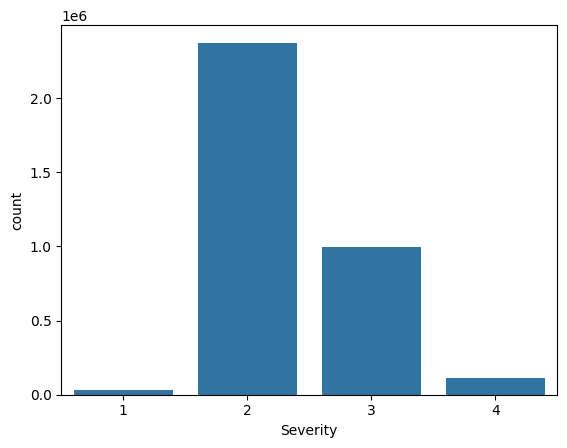

In [107]:
#@title
sb.countplot(x=acc_df['Severity'])

The data shows a clear inverse relationship between accident severity level and frequency. Severity level 2 (moderate) has the highest number of accidents (2,373,210), while severity level 1 (least severe) has the fewest (29,174). As severity increases to levels 3 and 4, the number of accidents decreases significantly (998,913 and 112,320 respectively). This suggests that while moderate-severity accidents are very common, high-severity accidents are relatively rare.

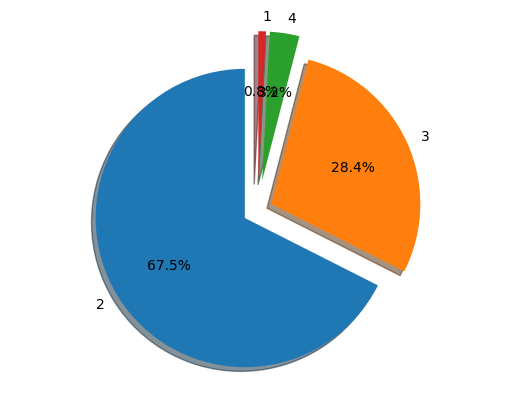

In [108]:
#@title
explode = (0.1, 0.1, 0.2 ,0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(severity_count['num_accidents'], explode=explode, labels=severity_count['severity_level'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

We note that the majority of the accidents fall into category 2 and 3 in terms of severity. We might have to deal with class imbalance issue.

In [109]:
#@title
#create a new column for severity category 4
acc_df['Severity4'] = 0
acc_df.loc[acc_df['Severity'] == 4, 'Severity4'] = 1
acc_df.Severity4.value_counts()

Severity4
0    3401297
1     112320
Name: count, dtype: int64

The binary column Severity4 is created to classify accidents into two categories: high-severity (level 4) and all other severity levels (1-3). This simplifies analysis by isolating the most severe accidents, enabling focused study of their unique patterns and risk factors.. Let's try to plot the US Car Accidents map with longitude and latitude where these most severe accidents usually happened.

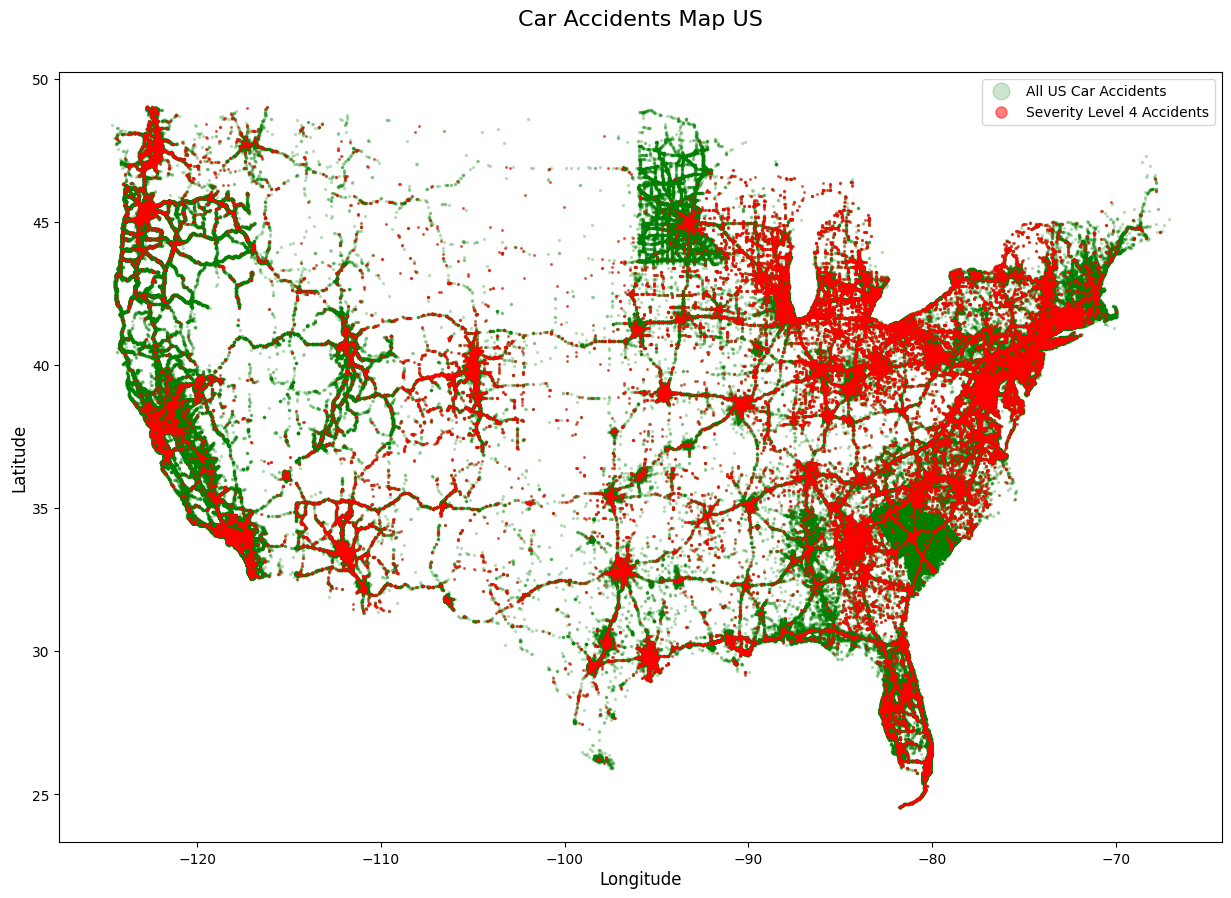

In [112]:
#@title
map_df = acc_df[acc_df['Severity4']==1]

plt.figure(figsize=(15,10))

plt.plot('Start_Lng', 'Start_Lat', data=acc_df, linestyle='', marker='o', markersize=1.5, color="green", alpha=0.2, label='All US Car Accidents')
plt.plot('Start_Lng', 'Start_Lat', data=map_df, linestyle='', marker='o', markersize=1, color="red", alpha=0.5, label='Severity Level 4 Accidents')
plt.legend(markerscale=8)
plt.xlabel('Longitude', size=12, labelpad=3)
plt.ylabel('Latitude', size=12, labelpad=3)
plt.title('Car Accidents Map US', size=16, y=1.05)
plt.show()

This visualization plots the geographical distribution of U.S. car accidents, comparing all accidents (teal dots) with high-severity (level 4) accidents (red dots). The map reveals that while accidents are widespread across the country, severity level 4 incidents appear clustered in certain regions, suggesting localized risk factors (e.g., high-speed highways, urban congestion, or hazardous weather). The higher opacity of red dots makes severe accidents stand out, emphasizing areas that may require targeted safety interventions.

## Data Preprocessing

###  Weather Condition

Weather conditions have a substantial correlation with car crashes, according to Perrels et al. (https://www.researchgate.net/publication/284903283_Weather_Conditions_Weather_Information_and_Car_Crashes), LLet's undertake some data preprocessing and examine this feature in more detail.

In [113]:
#@title
#look at unique values of weather condition
print("Weather Condition: ", "\n", acc_df['Weather_Condition'].unique())
print('\n')
print("Total Unique Conditions: ", acc_df['Weather_Condition'].nunique())

Weather Condition:  
 ['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Ligh

There are a total 127 unique weather conditions but a lot of them overlap. Let's try to group them together.

In [114]:
#@title
weather_cond ='!'.join(acc_df['Weather_Condition'].dropna().unique().tolist())
weather_cond = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather_cond))).tolist()
weather_cond

['',
 'Clear',
 'Cloudy',
 'Drifting Snow',
 'Drizzle',
 'Dust',
 'Dust Whirls',
 'Dust Whirls Nearby',
 'Dust Whirlwinds',
 'Fair',
 'Fog',
 'Funnel Cloud',
 'Hail',
 'Haze',
 'Heavy ',
 'Heavy Drizzle',
 'Heavy Ice Pellets',
 'Heavy Rain',
 'Heavy Rain Shower',
 'Heavy Rain Showers',
 'Heavy Sleet',
 'Heavy Smoke',
 'Heavy Snow',
 'Heavy T-Storm',
 'Heavy Thunderstorms',
 'Ice Pellets',
 'Light ',
 'Light Drizzle',
 'Light Fog',
 'Light Hail',
 'Light Haze',
 'Light Ice Pellets',
 'Light Rain',
 'Light Rain Shower',
 'Light Rain Showers',
 'Light Sleet',
 'Light Snow',
 'Light Snow Grains',
 'Light Snow Shower',
 'Light Snow Showers',
 'Light Thunderstorm',
 'Light Thunderstorms',
 'Low Drifting Snow',
 'Mist',
 'N/A Precipitation',
 'Overcast',
 'Partial Fog',
 'Patches of Fog',
 'Rain',
 'Rain Shower',
 'Rain Showers',
 'Sand',
 'Scattered Clouds',
 'Shallow Fog',
 'Showers in the Vicinity',
 'Sleet',
 'Small Hail',
 'Smoke',
 'Snow',
 'Snow Grains',
 'Snow Showers',
 'Squalls',
 '

There are still quite a lot of overlapping here. Let's come up with some major categories such as "Cloud", "Rain", "Snow", etc.

In [115]:
#@title
acc_df['Clear'] = np.where(acc_df['Weather_Condition'].str.contains('Clear', case=False, na = False), 1, 0)
acc_df['Cloud'] = np.where(acc_df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), 1, 0)
acc_df['Rain'] = np.where(acc_df['Weather_Condition'].str.contains('Rain|Storm|Hail|Drizzle', case=False, na = False), 1, 0)
acc_df['Heavy_Rain'] = np.where(acc_df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), 1, 0)
acc_df['Snow'] = np.where(acc_df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), 1, 0)
acc_df['Heavy_Snow'] = np.where(acc_df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na = False), 1, 0)
acc_df['Fog'] = np.where(acc_df['Weather_Condition'].str.contains('Fog', case=False, na = False), 1, 0)
acc_df['Dust'] = np.where(acc_df['Weather_Condition'].str.contains('Dust|Smoke|Ash|Haze', case=False, na = False), 1, 0)
acc_df['Thunder'] = np.where(acc_df['Weather_Condition'].str.contains('Thunder|T-Storm', case=False, na = False), 1, 0)

In [116]:
#@title
#handle missing value in weather
weather_clean = ['Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog', 'Dust', 'Thunder']

for w in weather_clean:
  acc_df.loc[acc_df['Weather_Condition'].isnull(),w] = acc_df.loc[acc_df['Weather_Condition'].isnull(),'Weather_Condition']

In [117]:
#@title
#take a look at a sample of clean data
acc_df.loc[:,['Weather_Condition'] + weather_clean].sample(20)

,Weather_Condition,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Dust,Thunder
2557742,Mostly Cloudy,0,1,0,0,0,0,0,0,0
1020089,Partly Cloudy,0,1,0,0,0,0,0,0,0
2922030,Mostly Cloudy,0,1,0,0,0,0,0,0,0
1315885,Scattered Clouds,0,1,0,0,0,0,0,0,0
3428729,Overcast,0,1,0,0,0,0,0,0,0
308471,Clear,1,0,0,0,0,0,0,0,0
1244203,Rain,0,0,1,0,0,0,0,0,0
2605167,Scattered Clouds,0,1,0,0,0,0,0,0,0
504520,Clear,1,0,0,0,0,0,0,0,0
3282472,Scattered Clouds,0,1,0,0,0,0,0,0,0


###  Wind Direction

We perform the same procedure with wind directions.

In [118]:
#@title
# unique value of wind direction
print("Wind Direction: ", acc_df['Wind_Direction'].unique())

Wind Direction:  ['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']


In [119]:

acc_df.loc[(acc_df['Wind_Direction']=='South')|(acc_df['Wind_Direction']=='SSW')|(acc_df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
acc_df.loc[(acc_df['Wind_Direction']=='West')|(acc_df['Wind_Direction']=='WSW')|(acc_df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
acc_df.loc[(acc_df['Wind_Direction']=='North')|(acc_df['Wind_Direction']=='NNW')|(acc_df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
acc_df.loc[(acc_df['Wind_Direction']=='East')|(acc_df['Wind_Direction']=='ESE')|(acc_df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
acc_df.loc[acc_df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
acc_df.loc[acc_df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'

print('Clean Wind Direction: ', acc_df['Wind_Direction'].unique())

Clean Wind Direction:  ['CALM' 'SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' nan]


Instead of using 30+ categories for wind direction, now we only have 10.

###  Street Type

According to this article (https://www.cga.ct.gov/2013/rpt/2013-R-0074.htm), there is a correlation between the number of accidents and speed limit hikes. We try to estimate the speed limit by determining the type of street, while it would be great to have data with the speed limit.

In [120]:
#@title
print("Number of Unique Street Type: ", acc_df['Street'].nunique())

Number of Unique Street Type:  176262


Not all 176k street kinds can be filtered down the way we were able to using weather conditions. Only the top 50 typical street types will be examined.

In [121]:
#@title
street_type =' '.join(acc_df['Street'].unique().tolist()) 
street_type = re.split(" |-", street_type) 
street_type = [x[0] for x in Counter(street_type).most_common(50)] 
print('50 Most Common Street Type: ')
print(*street_type, sep = ", ")

50 Most Common Street Type: 
Rd, , Dr, St, Ave, N, S, E, W, Ln, Blvd, Highway, Way, Ct, State, Hwy, NE, Pkwy, SW, Pl, SE, NW, Road, Old, Cir, Route, US, Creek, Hill, Park, County, Lake, Trl, Valley, Ridge, Mill, River, Pike, Oak, Ter, I, Loop, Canyon, Church, Springs, Bridge, Mountain, New, Avenue, Saint


We handpick some popular/common street types based on this information from USPS: https://pe.usps.com/text/pub28/28apc_002.htm

In [122]:
#@title
street_type = [' Ave', ' Blvd', ' Ct', ' Dr', ' Rd', ' St',  ' Ln', ' Highway', ' Pkwy', ' Hwy', 
          ' Way' , 'Pl', ' Road', 'US-', 'Creek', ' Cir', 'Hill', 'Route', 
          'I-', 'Trl', 'Valley', 'Ridge', 'Pike', ' Fwy', 'River']
print(*street_type, sep = ", ") 

 Ave,  Blvd,  Ct,  Dr,  Rd,  St,  Ln,  Highway,  Pkwy,  Hwy,  Way, Pl,  Road, US-, Creek,  Cir, Hill, Route, I-, Trl, Valley, Ridge, Pike,  Fwy, River


Let's look at the correlation between the street type and how severe an accident is.

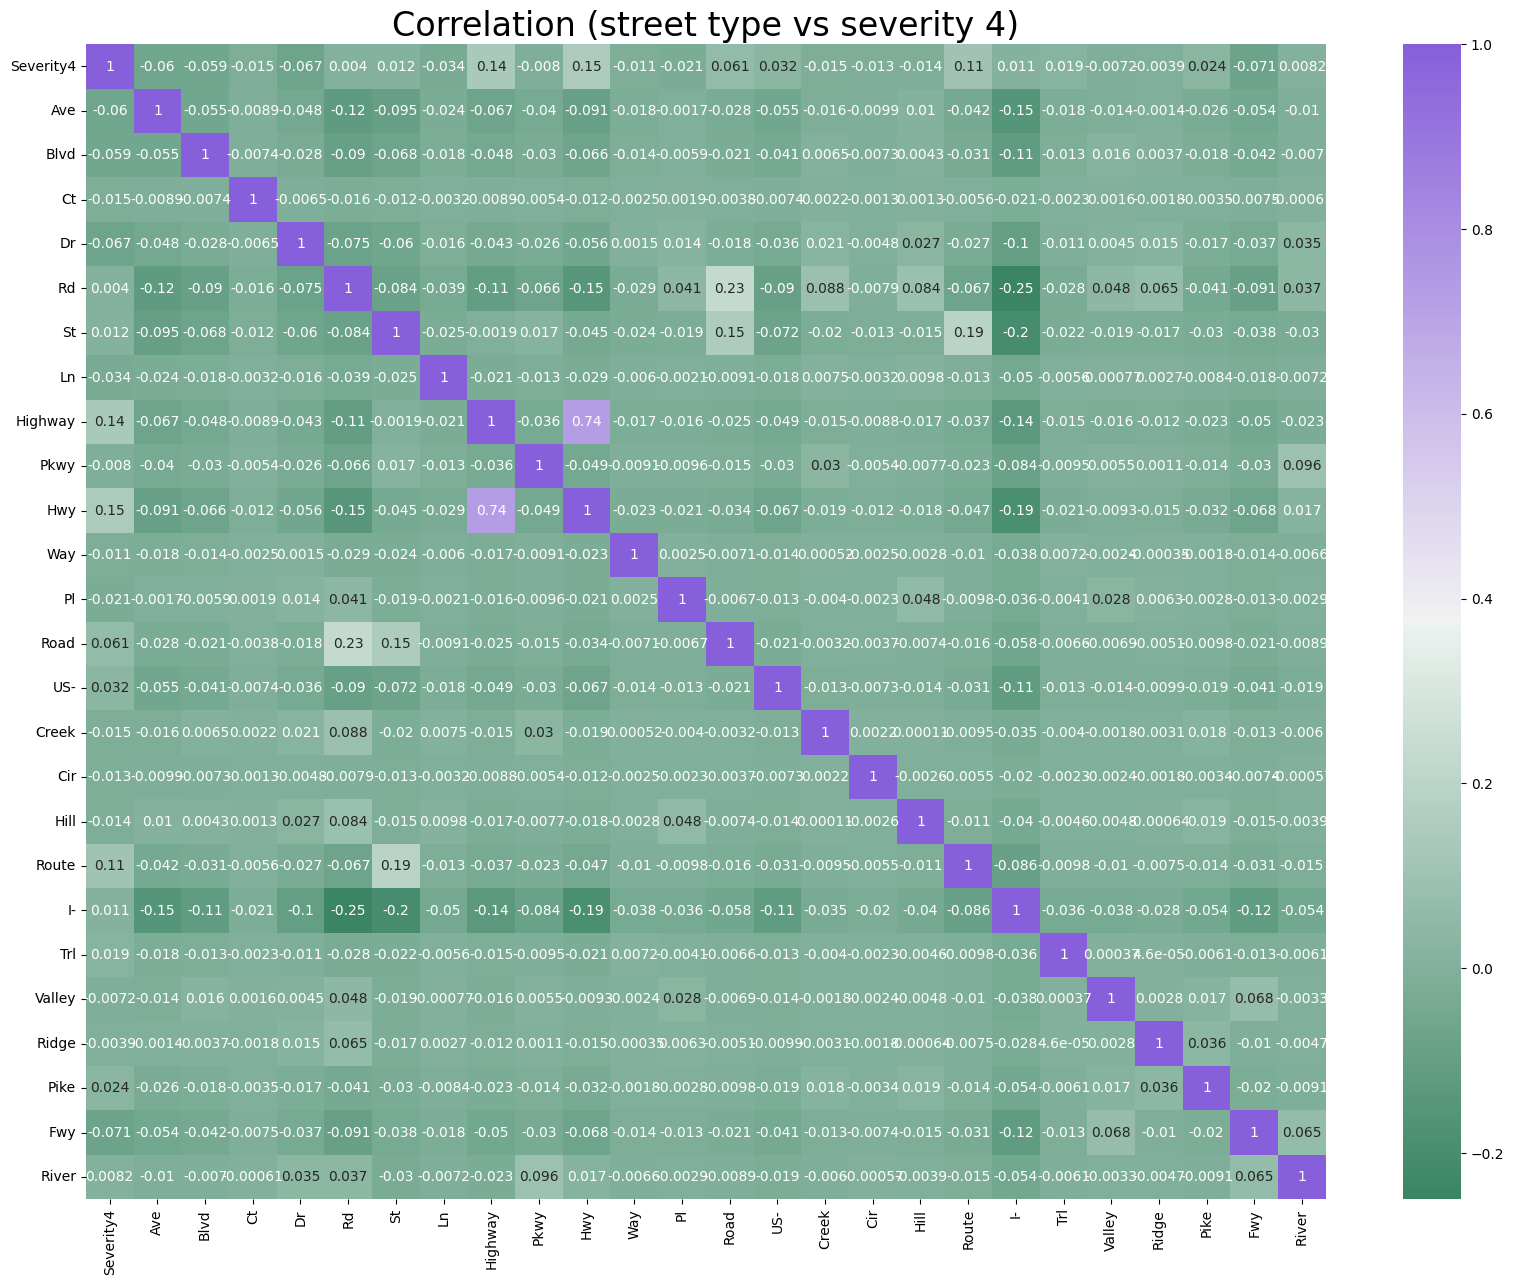

In [123]:
#@title
for i in street_type:
  acc_df[i.strip()] = np.where(acc_df['Street'].str.contains(i, case=True, na = False), 1, 0)
acc_df.loc[acc_df['Road']==1,'Rd'] = 1
acc_df.loc[acc_df['Highway']==1,'Hwy'] = 1

#resample due to the huge size of our data
df_sample = pd.concat([acc_df[acc_df['Severity4']==1].sample(50000, replace = True), 
                   acc_df[acc_df['Severity4']==0].sample(50000)], axis=0)

# plot correlation
df_sample['Severity4'] = df_sample['Severity4'].astype(int)
street_corr  = df_sample.loc[:,['Severity4']+[x.strip() for x in street_type]].corr()
plt.figure(figsize=(20,15))
cmap = sb.diverging_palette(150, 275, as_cmap=True)
sb.heatmap(street_corr, cmap=cmap, annot=True).set_title("Correlation (street type vs severity 4)", fontsize = 24)
plt.show()

The correlation matrix reveals varying relationships between road types and accident severity. Highways (Hwy) show the strongest positive correlation with severity level 4 (0.15), indicating that accidents on highways are more likely to be high-severity. In contrast, residential roads (Ave, St) exhibit weaker or negative correlations, suggesting lower-severity outcomes. Notably, "Rd" (Road) has a moderate correlation (0.23) with severity, possibly due to mixed traffic conditions. These patterns highlight that high-speed or high-traffic roads (e.g., highways) are disproportionately associated with severe accidents, while local roads are less risky.

##  Feature Engineering

In feature engineering, new features are created using existing features to see if they offer any new signals for outcome prediction. The time it takes to clear an accident may provide some insight into the severity of that accident, according to the EDA section. Together, let's attempt to extract this data!

###  Feature Extraction

In [23]:
#@title
#convert start time and end time to the right format
acc_df['Start_Time'] = pd.to_datetime(acc_df['Start_Time'], errors='coerce')
acc_df['End_Time'] = pd.to_datetime(acc_df['End_Time'], errors='coerce')

In [24]:
#@title
#extract year, month, day, hour, and weekday of the accident from start and end time
acc_df['Year']=acc_df['Start_Time'].dt.year
acc_df['Month']=acc_df['Start_Time'].dt.strftime('%b')
acc_df['Day']=acc_df['Start_Time'].dt.day
acc_df['Hour']=acc_df['Start_Time'].dt.hour
acc_df['Weekday']=acc_df['Start_Time'].dt.strftime('%a')

In [25]:
#@title
#calculate the duration of the accident in minute
acc_df['acc_duration(min)']=round((acc_df['End_Time']-acc_df['Start_Time'])/np.timedelta64(1,'m'))

In [26]:
#@title
#let's take a look at our new features
acc_df.head(2)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Ridge,Pike,Fwy,River,Year,Month,Day,Hour,Weekday,acc_duration(min)
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,0,0,0,0,2016,Feb,8,5,Mon,314.0
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,0,0,0,0,2016,Feb,8,6,Mon,30.0


### Outlier Analysis

We do a sanity check to find out if there are any outliers we need to handle from this new feature. There are negative durations that should be removed.

In [27]:
#@title
#records with negative duration
acc_df['acc_duration(min)'][acc_df['acc_duration(min)'] <= 0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
860988    -12.0
861024    -31.0
861041     -0.0
861475    -14.0
861494     -0.0
861495    -30.0
1497823   -30.0
1497824   -31.0
2234574   -30.0
2234659   -30.0
2234660   -31.0
3104499   -34.0
3104975    -7.0
3104978    -7.0
3232740   -31.0
Name: acc_duration(min), dtype: float64

In [28]:
#@title
#remove the records with negative duration
acc_df['acc_duration(min)'][acc_df['acc_duration(min)'] <= 0] = np.nan
acc_df.dropna(subset=['acc_duration(min)'], inplace=True)

Looking closer at the time it takes to clear an accident, we note something very unusual.

In [29]:
#@title
acc_df[acc_df['acc_duration(min)']==acc_df['acc_duration(min)'].max()]

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Ridge,Pike,Fwy,River,Year,Month,Day,Hour,Weekday,acc_duration(min)
2740847,A-2740902,Bing,NaN,2,2017-08-16 14:07:14,2020-04-30 01:22:43,40.02935,-80.31546,40.02935,-80.31546,...,0,0,0,0,2017,Aug,16,14,Wed,1421955.0
2740848,A-2740903,Bing,NaN,2,2017-08-16 14:07:14,2020-04-30 01:22:43,40.02935,-80.31546,40.02935,-80.31546,...,0,0,0,0,2017,Aug,16,14,Wed,1421955.0


It took us nearly three years to recover from this accident! It doesn't look correct. It might be the result of a data entering error, or it might be the time required to resolve this accident. But let's exclude these outliers as we don't want them to distort our data. Eliminating any records with accident durations longer than two standard deviations from the mean accident duration is a safe method to accomplish this.


In [30]:
#@title
#remove observations that have accident duration which is greater than 2 standard deviation from the mean

outliers = (acc_df['acc_duration(min)'] - acc_df['acc_duration(min)'].mean()).abs() > acc_df['acc_duration(min)'].std()*2
acc_df[outliers] = np.nan
acc_df['acc_duration(min)'].fillna(acc_df['acc_duration(min)'].mean(), inplace=True)

Let's plot out the distribution of the accident duration feature!

<Axes: xlabel='acc_duration(min)', ylabel='Density'>

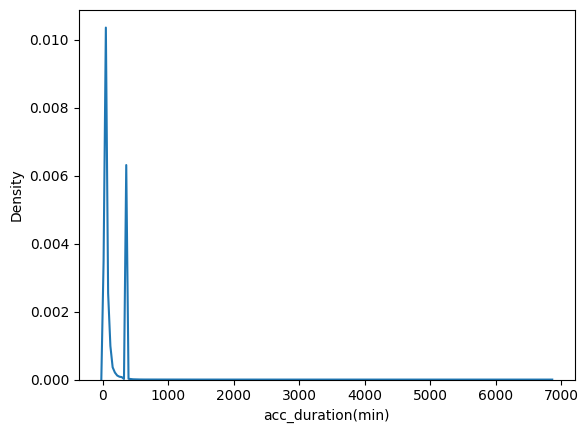

In [31]:
#@title
sb.kdeplot(data=acc_df, x="acc_duration(min)")

###  Handling Missing Data

Our data set has a large number of missing values. Missing values can be problematic since some algorithms will fail because they are unable to accept null values. Others, such as decision trees, are capable of managing null values. Therefore, it's critical to deal with this issue prior to beginning modeling. There are two popular approaches: either remove the record or use an acceptable input to fill in the missing data. In general, it is not advised to remove a record—especially one that contains a significant portion of records—unless it is indeed an incomplete record. Imputing missing values is the most effective method. Let's see how many missing values there are in each column feature.

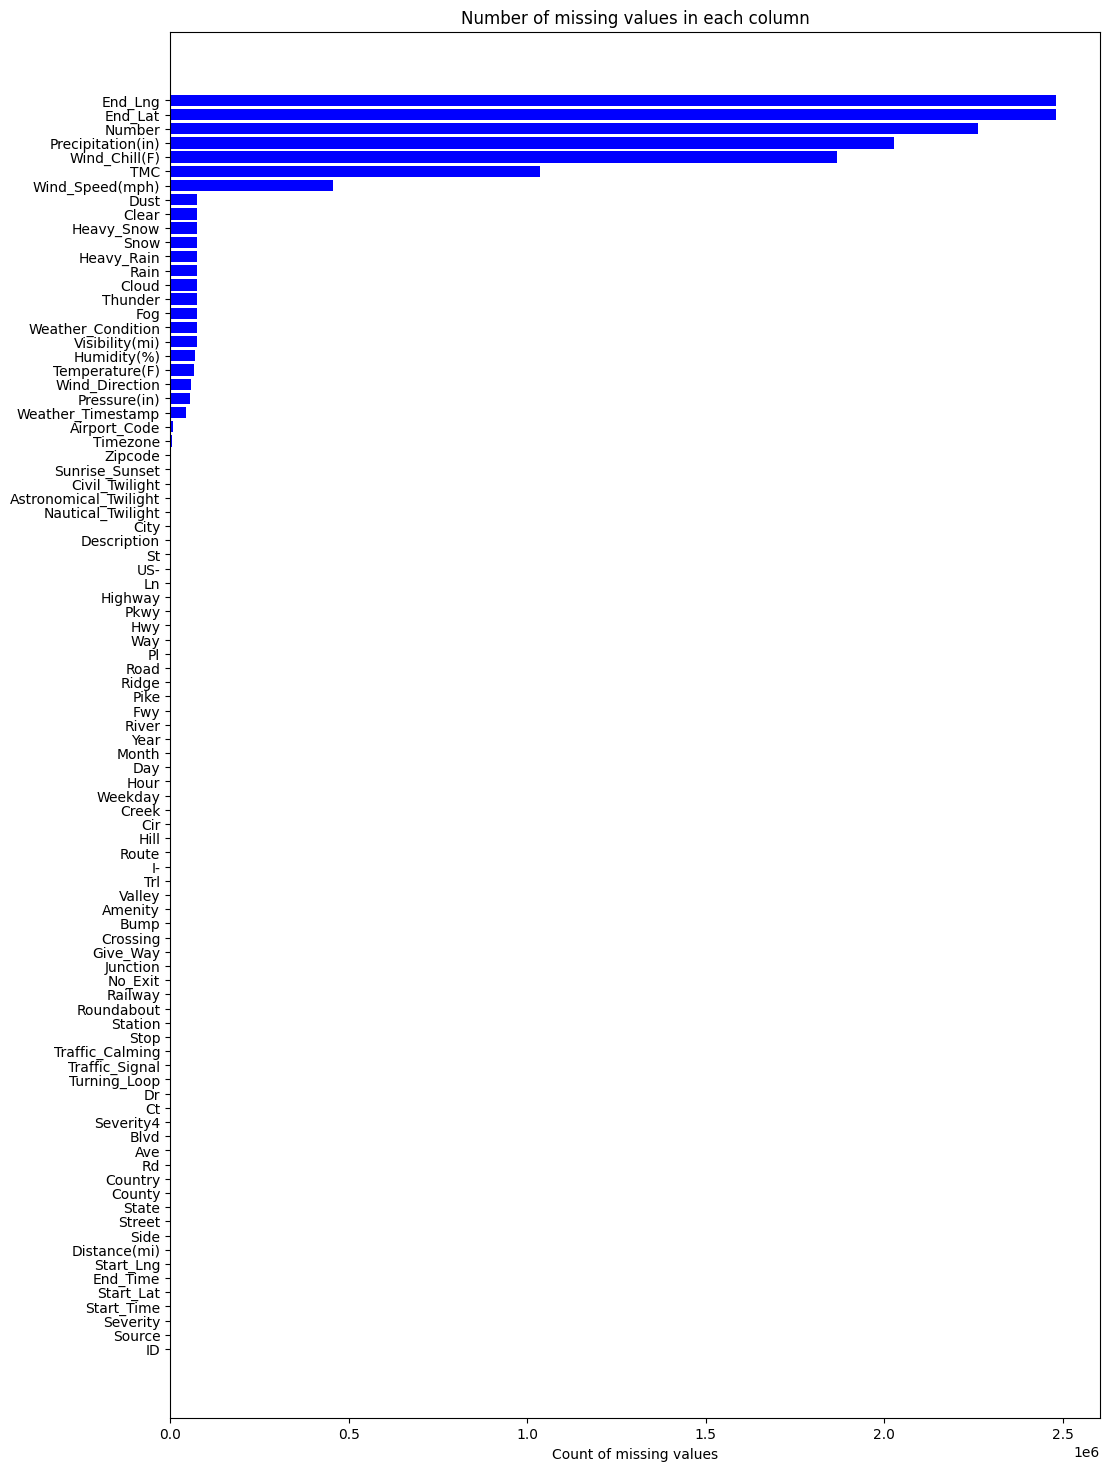

In [32]:
#@title
missing_df = acc_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Although deleting records with missing values is not advised, we have a large amount of data—possibly more than we'll require to train our classifier. We made the decision to take this path within the parameters of our project. 

Due to the massive amount of data, it will take a long time to train our models. We decided to train with a subset of the available data. We filter out all the records from PA state as our chosen subset. Below is a quick look at PA and where the accidents happened.

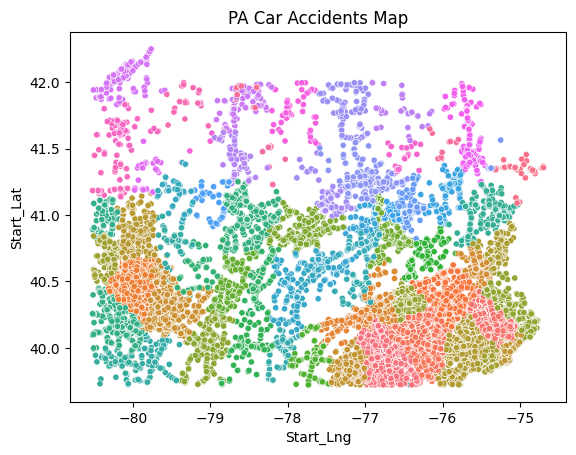

In [33]:
#@title
state = 'PA'
df_state = acc_df.loc[acc_df['State']==state].copy()
df_state.drop('State',axis=1, inplace=True)
sb.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20).set_title('PA Car Accidents Map')
plt.show()

Next step is to decide what features we're going to use for our model. We do not include IDs, number, street side, country, timezone, airport, weather time stamp, and other columns with a lot of missing values (end_lat, end_lng, precipitation, etc.) 

In [34]:

#exclude ID - no predictive power
#number, street side, country, timezone, airport(?), weather time stamp
#columns with a lot of missing values

#state, airport_code

col_to_use = ['Start_Lat', 'Start_Lng', 'State', 
              
              'Ave', 'Blvd', 'Ct', 'Dr', 'Rd', 'St',  'Ln', 'Highway', 'Pkwy', 'Hwy', 
              'Way' , 'Pl', 'Road', 'US-', 'Creek', 'Cir', 'Hill', 'Route', 
              'I-', 'Trl', 'Valley', 'Ridge', 'Pike', 'Fwy', 'River',

              'Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
              
              'Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog', 'Dust', 'Thunder',

              'Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop',
              'Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight',
              'Astronomical_Twilight', 'Hour','Weekday', 'acc_duration(min)', 'Severity']

In [35]:
#@title
#create a new dataframe with the columns we need
acc_df = acc_df[col_to_use]

In [36]:
#@title
#drop records with missing values
acc_df.dropna(subset=acc_df.columns[acc_df.isnull().mean()!=0], how='any', axis=0, inplace=True)
acc_df.shape

(3402007, 63)

Even after dropping all the records with missing values, we are still left with a bit more than 3.4 million records.

In [37]:
#@title
state = 'PA'
df_state = acc_df.loc[acc_df['State']==state].copy()
df_state.drop('State',axis=1, inplace=True)

In [38]:
#@title
df_state.shape

(104297, 62)

We have more thann 100k records from PA. This should be enough to train our model.

### Data Scaling and Standardizing

Before training our classifiers, we need to convert categorical values to numeric values, standardize the values, and split the data into training set and testing set. Note that to deal with class imbalance issue, we use stratify method when splitting the data to keep the ratios among different categories.

In [39]:
#@title
#one-hot encode to convert categorical to numerical
df_state = pd.get_dummies(df_state)
df_state.shape

(104297, 101)

In [40]:
#@title
#standadize the data
scaler = StandardScaler()
scaler.fit_transform(df_state)
df_state.head()

,Start_Lat,Start_Lng,Ave,Blvd,Ct,Dr,Rd,St,Ln,Highway,...,Nautical_Twilight_Night,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed
197865,41.338398,-74.837120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,True,False,False,False,False,False
208994,41.408066,-74.914040,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,True
214862,41.324230,-74.806488,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,True
228550,40.057697,-76.765587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,True
228553,40.301609,-75.647789,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,True


In [41]:
#@title
#extract y label
y = df_state['Severity']

In [42]:
#@title
#feature columns
X = df_state.drop('Severity', axis=1)

In [43]:
#@title
#train-test-split with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## Classification Models

In this project, multiple classification models such as Logistic Regression, K-Nearest Neighbors (KNN), Decision Tree, Random Forest, AdaBoost, XGBoost, LightGBM, and LSTM were employed to predict the severity category of individual car accidents based on various features such as time, location, weather conditions, and traffic attributes. These models are ideal for structured, tabular data and allow for effective comparison between simple linear models (e.g., Logistic Regression) and more complex ensemble methods (e.g., Random Forest, XGBoost, and LightGBM). Using a variety of classifiers helps to identify which algorithm best captures the underlying patterns in the data while handling class imbalance and non-linear relationships. The inclusion of LSTM in classification also allows for capturing temporal dependencies when severity is influenced by time-sequenced events or patterns.

###  Logistic Regression
Logistic Regression is an intuitive and easy-to-understand linear classification algorithm. It works well for problems where there is a linear relationship between the input features and the target. However, its major limitation is the assumption of linearity, which makes it less effective for complex or non-linear problems. In real-world scenarios where data is rarely linearly separable, Logistic Regression is often outperformed by more advanced models

In [45]:
#@title
lr = LogisticRegression(max_iter = 3000)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy: %.1f%%"% (acc_lr*100))

Logistic Regression Accuracy: 80.5%


Logistic Regression reached 80.5% accuracy, serving as a strong baseline model that is fast and easy to interpret.
This indicates it can identify general trends in accident severity but may miss subtle or non-linear interactions in the data.

### K-Nearest Neighbor
K-Nearest Neighbors is a simple, non-parametric algorithm that classifies data points based on the majority label of their closest neighbors. It makes no assumptions about the underlying data distribution, which makes it flexible for various problem types. However, KNN can be computationally expensive and sensitive to irrelevant features and feature scaling.

In [46]:
%%time
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred)
print("KNN Accuracy: %.1f%%"% (acc_knn*100))

KNN Accuracy: 75.6%
CPU times: total: 26 s
Wall time: 6.43 s


KNN resulted in 75.6% accuracy, performing moderately well but affected by the dataset’s high dimensionality and sparsity.
This accuracy suggests that while it can detect patterns from similar past accidents, it struggles with complex decision boundaries.

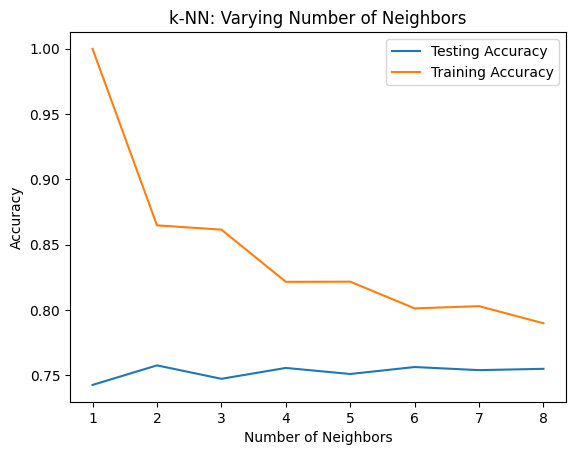

CPU times: total: 12min 35s
Wall time: 1min 53s


In [47]:
%%time
# find the best k
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, n_neighbor in enumerate(neighbors):

    knn = KNeighborsClassifier(n_neighbors=n_neighbor)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

We did some hyperparameter tuning to find the best k, but its accuracy is still pretty bad.

### Decision Tree
Decision Tree is a tree-structured classifier that splits the data into subsets based on feature values. It is easy to interpret and works well with both numerical and categorical data. However, decision trees are prone to overfitting, especially with deep trees, and may not generalize well to unseen data without pruning or regularization.

In [49]:
#@title

dt1 = DecisionTreeClassifier(max_depth=50, criterion='entropy')
dt1.fit(X_train,y_train)
y_pred = dt1.predict(X_test)

acc_dt1 = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy (Entropy): %.1f%%"% (acc_dt1*100))
print('\n')

dt2 = DecisionTreeClassifier(max_depth=50, criterion='gini')
dt2.fit(X_train,y_train)
y_pred = dt2.predict(X_test)

acc_dt2 = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy (Gini): %.1f%%"% (acc_dt2*100))


Decision Tree Accuracy (Entropy): 86.8%


Decision Tree Accuracy (Gini): 86.5%


The Decision Tree classifier achieved an accuracy of 86.8%, making it a good interpretable model with reasonable predictive power.
It correctly classifies accident severity in most cases, though its simplicity may limit its ability to generalize to more complex data patterns.

###  Random Forest
Random Forest is an ensemble method that builds multiple decision trees and aggregates their results to improve prediction accuracy and reduce overfitting. By averaging the predictions from diverse trees, it increases robustness and generalization. However, it can be less interpretable and computationally heavier than a single tree.

In [52]:
#@title

rf = RandomForestClassifier(n_estimators=500, max_depth=50)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy: %.1f%%"% (acc_rf*100))

Random Forest Accuracy: 89.5%


Random Forest performed well with 89.5% accuracy, leveraging an ensemble of decision trees to improve prediction stability and reduce overfitting.
In practical terms, this means it reliably classifies accident severity across a wide range of input conditions and feature interactions.

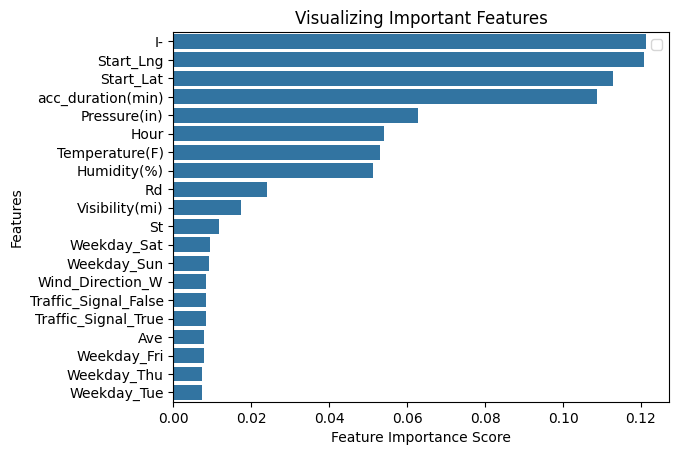

In [53]:
#@title
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)


k=20
sb.barplot(x=feature_imp[:20], y=feature_imp.index[:k])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [54]:
#@title

depth = [10,30,50]
nEstimator = [100,200,500]

grid = {'n_estimators' : nEstimator, 'max_depth': depth}

random_forest = RandomForestClassifier()

grid_search = GridSearchCV(estimator = random_forest, param_grid = grid)
grid_search.fit(X_train,y_train)

y_pred = grid_search.predict(X_test)

acc_grid = accuracy_score(y_test, y_pred)
print("Grid Search Accuracy: %.1f%%"% (acc_grid*100))


Grid Search Accuracy: 89.5%


We use GridSearchCV to hyper-parameter tune our random forest.

### AdaBoost
AdaBoost (Adaptive Boosting) combines multiple weak learners, typically shallow decision trees, to form a strong classifier. It iteratively adjusts weights to focus more on previously misclassified instances. While it often improves accuracy, AdaBoost can be sensitive to noisy data and outliers.


In [55]:
#@title

ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.01)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred)
print("AdaBoost Accuracy: %.1f%%"% (acc_ada*100))


AdaBoost Accuracy: 72.9%


AdaBoost had the lowest accuracy at 72.9%, possibly due to its sensitivity to noise and misclassified examples.
While it still performs better than random guessing, it may not be the most reliable model for accurately predicting severity in diverse conditions.

###  XGBoost
XGBoost (Extreme Gradient Boosting) is an advanced implementation of gradient boosting that is optimized for speed and performance. It adds regularization to reduce overfitting and supports parallel processing. XGBoost is widely used in data science competitions, although it requires careful tuning for optimal performance.

In [57]:
y_train = np.array(y_train) - 1  # [1,2,3,4] → [0,1,2,3]
y_test = np.array(y_test) - 1     # Apply same to test data

# Now train XGBoost
gbm = xgb.XGBClassifier(n_estimators=1000, max_depth=20)
gbm.fit(X_train, y_train)  

# Predict and evaluate
y_pred = gbm.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy: %.1f%%" % (acc_xgb * 100))

XGBoost Accuracy: 91.6%


XGBoost achieved the highest accuracy of 91.6%, demonstrating its strength in capturing complex patterns in accident severity classification.
This means that the model correctly predicted the severity level of traffic accidents over 91 times out of 100, showing excellent reliability for risk assessment.

### LightGBM
LightGBM is a highly efficient gradient boosting algorithm that uses histogram-based techniques and grows trees leaf-wise. It is particularly well-suited for large datasets and offers faster training and lower memory usage than many alternatives. However, it may overfit on small datasets and can be more complex to interpret.

In [58]:

lgbm = lgb.LGBMClassifier(n_estimators=1000, max_depth=50)

lgbm.fit(X_train,y_train)

y_pred = lgbm.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred)
print("LightGBM Accuracy: %.1f%%"% (acc_lgb*100))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 78222, number of used features: 95
[LightGBM] [Info] Start training from score -6.198402
[LightGBM] [Info] Start training from score -0.305699
[LightGBM] [Info] Start training from score -1.570781
[LightGBM] [Info] Start training from score -2.928522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LightGBM followed closely with 91.4% accuracy, offering fast computation and high performance on large, structured data.
Such high accuracy indicates that the model effectively learned the underlying patterns associated with different severity levels of road accidents.

### Deep Learning

In [64]:
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [65]:
text_df = pd.read_csv('US_Accidents_June20.csv')

In [66]:
text_df = text_df[['Description', 'Severity']].sample(n=50000, random_state=42)

In [67]:
text_df['Description']

3173614    Between Amsterdam Ave/Harlem River Dr and RT-9...
2560694                          At I-75/Exit 43 - Accident.
708186     Accident on I-520 Bobby Jones Expy Eastbound a...
2231588    Lane blocked and left hand shoulder blocked du...
1755423    Left lane blocked due to accident on I-87 Nort...
                                 ...                        
1221870    Accident on entry ramp to I-105 Westbound from...
1819282    Accident on Expressway Northbound at Columbia Rd.
2299676                    Accident on Lake Blvd at Club Dr.
2142067    Accident on US-61 Hastings Rd Southbound betwe...
1811559           Accident on Harvey Rd at Poplar Drive Ext.
Name: Description, Length: 50000, dtype: object

In [68]:
# The maximum number of words to be used (most frequent)
max_num_words = 100
# Max number of words in each complaint
max_len = 500

embed_dim = 100
tokenizer = Tokenizer(num_words=max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_df['Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14586 unique tokens.


In [69]:
X = tokenizer.texts_to_sequences(text_df['Description'].values)
X = pad_sequences(X, maxlen=max_len)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(text_df['Severity']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (50000, 500)
Shape of label tensor: (50000, 4)


In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(45000, 500) (45000, 4)
(5000, 500) (5000, 4)


In [71]:
model = Sequential()
model.add(Embedding(max_num_words, embed_dim, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Epoch 1/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 662s 1s/step - accuracy: 0.8301 - loss: 0.4895 - val_accuracy: 0.9013 - val_loss: 0.3003
Epoch 2/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 645s 1s/step - accuracy: 0.9069 - loss: 0.2917 - val_accuracy: 0.9060 - val_loss: 0.2888
Epoch 3/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.9077 - loss: 0.2813 - val_accuracy: 0.9060 - val_loss: 0.2783
Epoch 4/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 711s 1s/step - accuracy: 0.9097 - loss: 0.2749 - val_accuracy: 0.9062 - val_loss: 0.2789
Epoch 5/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 711s 1s/step - accuracy: 0.9104 - loss: 0.2708 - val_accuracy: 0.9069 - val_loss: 0.2774
Epoch 6/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 720s 1s/step - accuracy: 0.9114 - loss: 0.2637 - val_accuracy: 0.9067 - val_loss: 0.2727
Epoch 7/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.9102 - loss: 0.2658 - val_accuracy: 0.9060 - val_loss: 0.2734
Epoch 8/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 578s 912ms/step - accuracy: 0.9136 - loss: 0.2540 - val_a

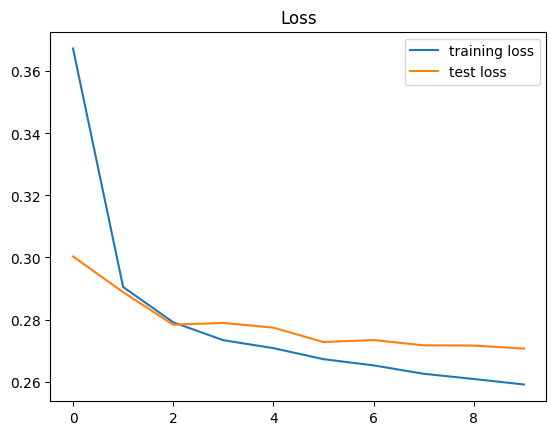

In [72]:
plt.title('Loss')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show();

In [73]:
acc_lstm = model.evaluate(X_test,Y_test)
print('LSTM accuracy: %.1f%%'% (acc_lstm[1]*100))

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9022 - loss: 0.2850
LSTM accuracy: 91.0%


The LSTM model reached 91.0% accuracy, showing strong performance in modeling the sequential and temporal nature of accident features.
This reflects LSTM’s ability to capture time-based dependencies, helping predict how severe an accident is likely to be based on past trends.

### Model comparison table

In [124]:
import pandas as pd

# Define the models and their accuracy scores
model_results = {
    'Logistic Regression': 80.5,
    'K-Nearest Neighbors': 75.6,
    'Decision Tree': 86.8,
    'Random Forest': 89.5,
    'AdaBoost': 72.9,
    'XGBoost': 91.6,
    'LightGBM': 91.4,
    'LSTM': 91.0
}

# Convert to DataFrame
results_df = pd.DataFrame(list(model_results.items()), columns=['Model', 'Accuracy (%)'])

# Sort by Accuracy (optional)
results_df = results_df.sort_values(by='Accuracy (%)', ascending=False).reset_index(drop=True)

# Display the table
results_df

,Model,Accuracy (%)
0,XGBoost,91.6
1,LightGBM,91.4
2,LSTM,91.0
3,Random Forest,89.5
4,Decision Tree,86.8
5,Logistic Regression,80.5
6,K-Nearest Neighbors,75.6
7,AdaBoost,72.9


Based on the evaluation results, XGBoost emerged as the most effective and reliable model for predicting car accident severity, achieving the highest accuracy of 91.6%. It was closely followed by LightGBM and LSTM, which also demonstrated strong performance above 91%, indicating their ability to capture complex patterns and temporal relationships in the data. Ensemble models like Random Forest and AdaBoost showed decent performance, though AdaBoost lagged behind with the lowest accuracy. Simpler models such as Logistic Regression, KNN, and Decision Tree served as useful baselines, but they were outperformed by more advanced methods. Overall, gradient boosting methods and deep learning models proved to be the most robust choices for severity prediction, providing both high accuracy and reliability for practical use in accident risk assessment.

## Time Series Forecasting Models
In addition to classification, time series forecasting models such as Persistence (Baseline), Exponential Smoothing, ARIMA, Prophet, and LSTM were utilized to predict the average daily severity of accidents over time. These models are specifically designed to handle temporal data and uncover seasonality, trends, and autocorrelation patterns that evolve over time. This forecasting approach supports long-term planning and resource allocation for stakeholders like insurance companies or traffic safety departments. Traditional statistical models like ARIMA and Exponential Smoothing provide strong baselines for comparison, while Prophet adds flexibility in handling seasonality and holiday effects. LSTM is particularly useful in this context for modeling complex, non-linear temporal dependencies and learning from sequential patterns that classical methods might miss.

### Data Preparation for Time Series

In [79]:
# Convert to time series format
# Reload the original data for time series analysis
time_series_df = pd.read_csv('US_Accidents_June20.csv', usecols=['Start_Time', 'Severity'])

# Convert to datetime and set as index
time_series_df['Start_Time'] = pd.to_datetime(time_series_df['Start_Time'])
time_series = time_series_df.set_index('Start_Time')

# Then continue with your time series analysis...
# Resample by day and calculate average severity
daily_severity = time_series['Severity'].resample('D').mean().ffill()

# Split into train and test (last 30 days as test)
train = daily_severity[:-30]
test = daily_severity[-30:]

In [93]:
# Check the date range in the dataset
print("Earliest accident record:", time_series_df['Start_Time'].min())
print("Latest accident record:  ", time_series_df['Start_Time'].max())

# Optional: also check how many unique days are covered
print("Total unique days in data:", time_series_df['Start_Time'].dt.date.nunique())


Earliest accident record: 2016-02-08 00:37:08
Latest accident record:   2020-06-30 23:18:09
Total unique days in data: 1601


### Persistence Model (Baseline)

The Persist model, or naïve forecast, is the simplest baseline method for time series prediction. It assumes that the next value in the series will be the same as the last observed value. This model is useful for benchmarking more complex algorithms, as any sophisticated model should outperform it. Despite its simplicity, it works surprisingly well for highly persistent data.

Persistence RMSE: 0.062


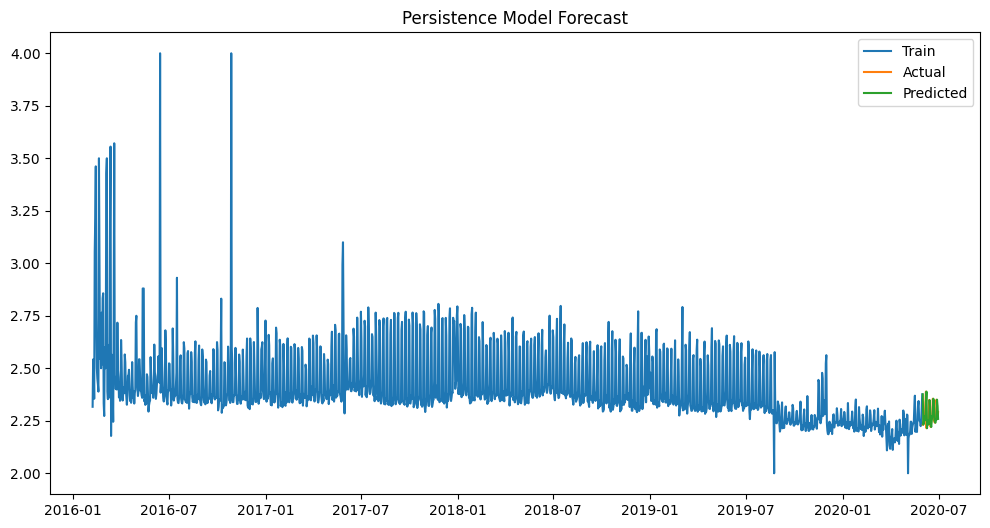

In [80]:
from sklearn.metrics import mean_squared_error

# Walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # Predict the next value as the last observed value
    yhat = history[-1]
    predictions.append(yhat)
    # Add actual observation to history
    history.append(test[i])
    
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Persistence RMSE: %.3f' % rmse)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('Persistence Model Forecast')
plt.legend()
plt.show()

The persistence model for car accident severity forecasting, spanning 2016 to 2020, achieves an RMSE of 0.062. The predicted values closely follow the actual severity trends in the test period, though they slightly underestimate some fluctuations. This baseline model provides a reasonable starting point but may benefit from more advanced techniques for improved accuracy.

### ARIMA Model (AutoRegressive Integrated Moving Average)

ARIMA is a classical statistical model for time series forecasting that combines autoregression (AR), differencing (I), and moving averages (MA). It is effective for stationary data or data that can be made stationary through differencing. The model's parameters (p, d, q) must be carefully tuned to capture trends and seasonality. ARIMA is widely used due to its interpretability and flexibility.

Best ARIMA order: (2, 1, 2) with AIC: -1850.83
ARIMA(2, 1, 2) RMSE: 0.045


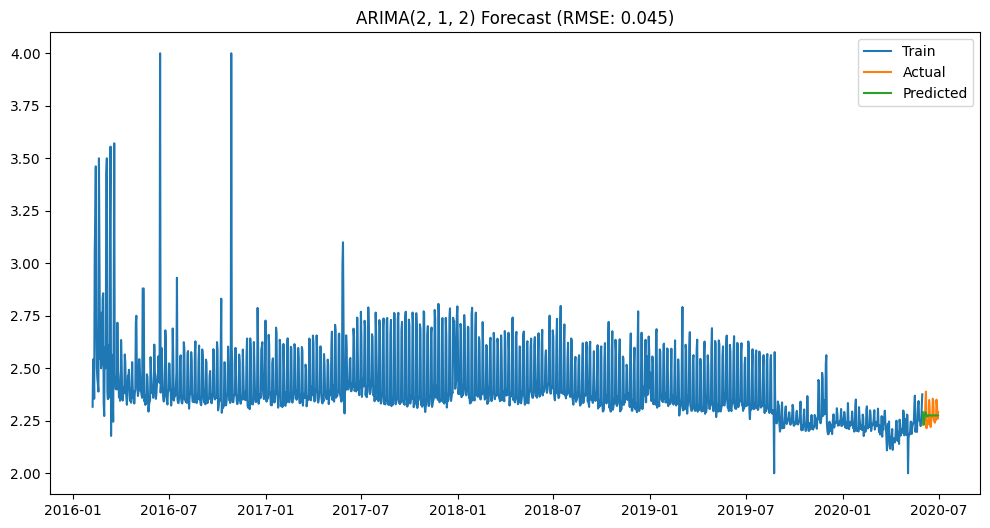

In [83]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings
warnings.filterwarnings("ignore")

# Define parameter ranges to search
p = d = q = range(0, 3)  # Try values 0-2 for p, d, q
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None

# Grid search for best ARIMA parameters
for order in pdq:
    try:
        model = ARIMA(train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")

# Fit model with best parameters
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"ARIMA{best_order} RMSE: {rmse:.3f}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted')
plt.title(f'ARIMA{best_order} Forecast (RMSE: {rmse:.3f})')
plt.legend()
plt.show()

The ARIMA(2, 1, 2) model, with an RMSE of 0.045 and an AIC of -1850.83, appears to be a good fit for forecasting car accident severity from 2016 to 2020. The predicted values closely align with the actual values in the test period, indicating effective capture of trends and patterns. The low RMSE and strong visual consistency suggest it performs well, though further validation with additional metrics or data could confirm its reliability.

### Exponential Smoothing (Holt-Winters)

Exponential Smoothing models forecast future values by assigning exponentially decreasing weights to past observations. Variants like Holt-Winters extend it to handle trends and seasonality. It is computationally efficient and works well for short-term forecasting. The method is particularly useful when data exhibits clear patterns without complex dependencies.

Exponential Smoothing RMSE: 0.029


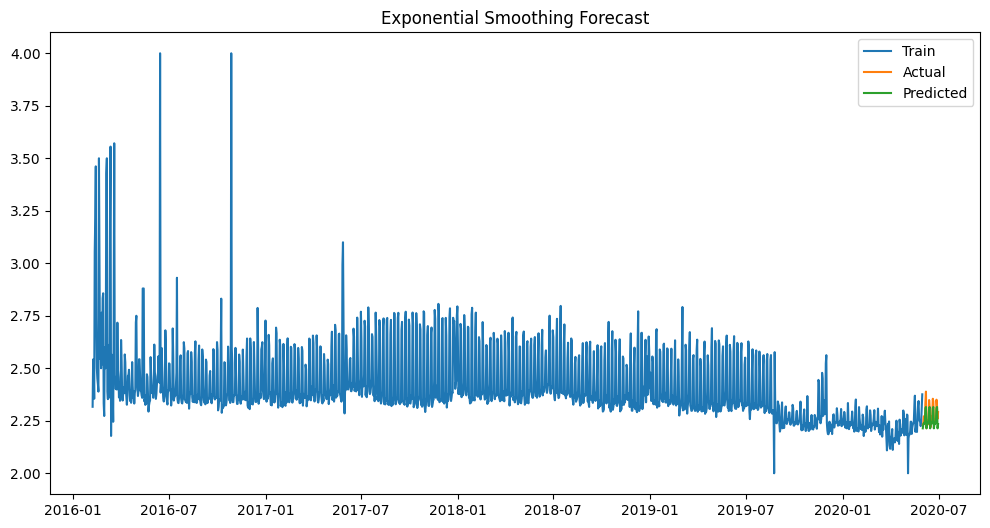

In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit model
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(len(test))
forecast = pd.Series(forecast, index=test.index)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print('Exponential Smoothing RMSE: %.3f' % rmse)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

The exponential smoothing model for car accident severity forecasting, with an RMSE of 0.029, demonstrates strong performance over the 2016-2020 period. The predicted values closely match the actual values in the test phase, indicating effective trend capturing with minimal error. This model's lower RMSE compared to ARIMA (0.045) and persistence (0.062) suggests it may be the best fit among the evaluated methods.

### Prophet Model

Prophet is designed for business time series with strong seasonal effects and holidays. It decomposes data into trend, seasonality, and holiday components, making it robust to missing data and outliers. Prophet is user-friendly and automatically handles many practical challenges, making it popular for forecasting at scale.

16:02:05 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 0.079


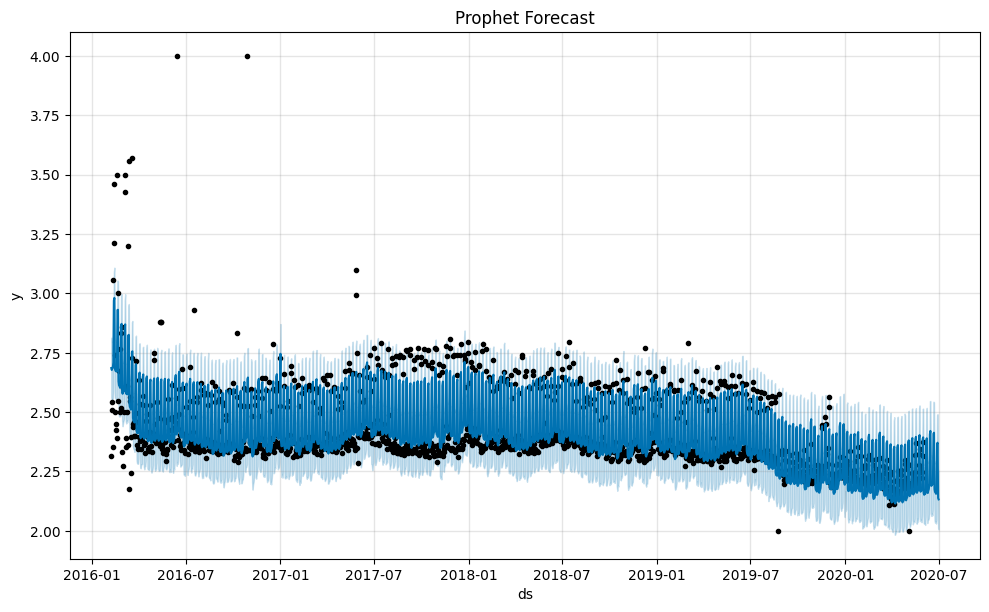

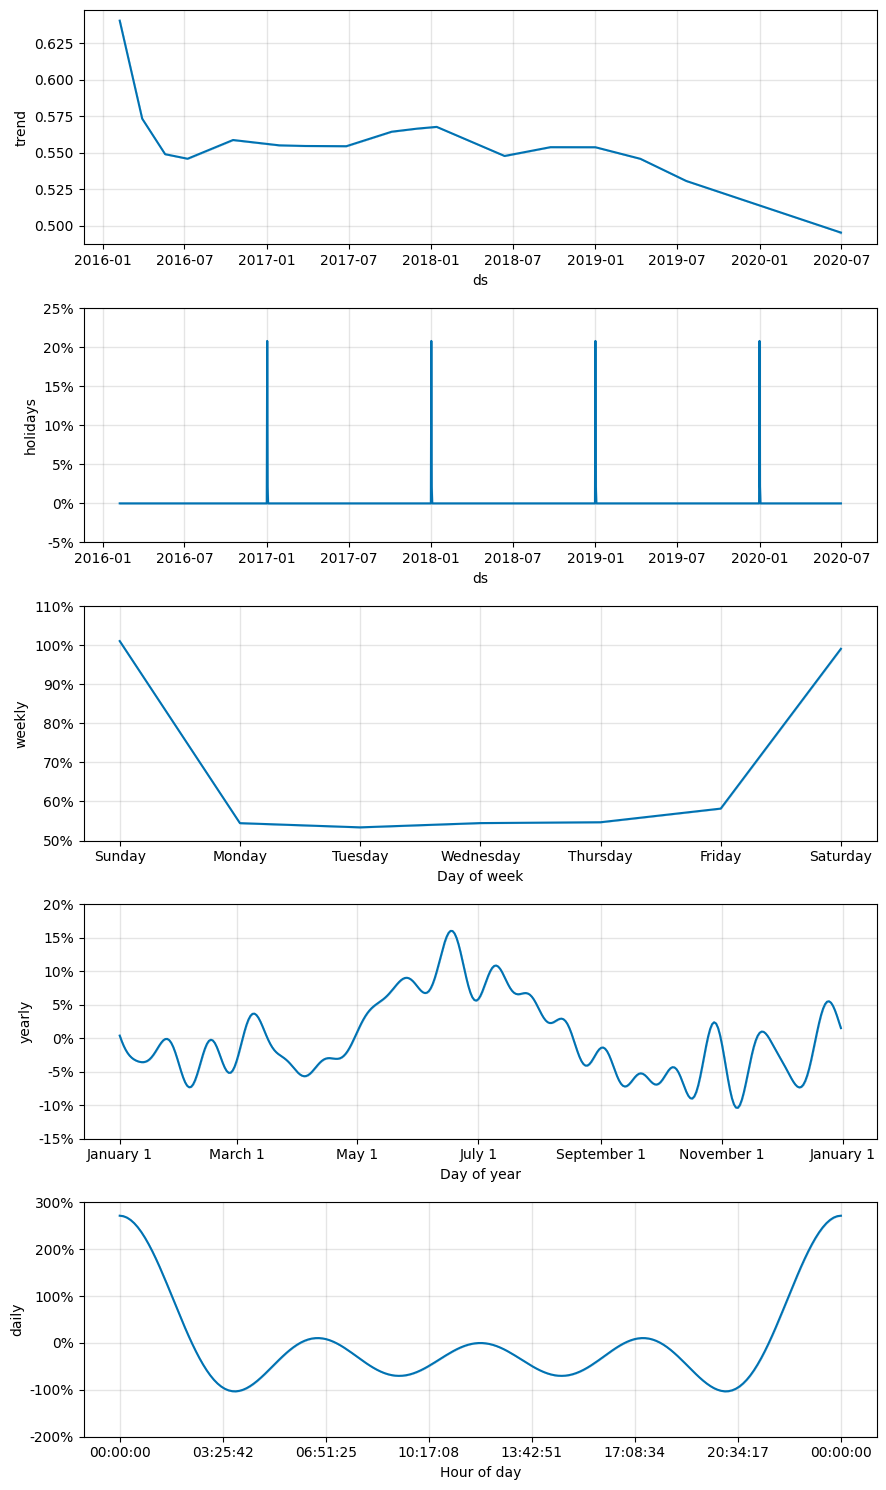

In [94]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Prepare data for Prophet
prophet_df = daily_severity.reset_index()
prophet_df.columns = ['ds', 'y']
train_p = prophet_df[:-30]
test_p = prophet_df[-30:]

# Define holidays (example: you can customize this based on your data)
holidays = pd.DataFrame({
    'holiday': 'new_year',
    'ds': pd.to_datetime(['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']),
    'lower_window': 0,
    'upper_window': 1,
})

# Fit model with tuned parameters
model = Prophet(
    seasonality_mode='multiplicative',  # Keep multiplicative for now
    changepoint_prior_scale=0.1,       # Make model more flexible to trend changes
    seasonality_prior_scale=10.0,      # Default seasonality flexibility
    holidays=holidays,                 # Add holidays
    yearly_seasonality=20,             # Increase Fourier order for yearly seasonality
    weekly_seasonality=10,             # Increase Fourier order for weekly seasonality
    daily_seasonality=True             # Ensure daily seasonality is enabled
)
model.fit(train_p)

# Make future dataframe
future = model.make_future_dataframe(periods=30)

# Forecast
forecast = model.predict(future)

# Calculate RMSE
predicted = forecast['yhat'][-30:].values
actual = test_p['y'].values
rmse = np.sqrt(mean_squared_error(actual, predicted))
print('Prophet RMSE: %.3f' % rmse)

# Plot
fig = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Optional: Plot components to understand trends and seasonality
fig2 = model.plot_components(forecast)
plt.show()

The Prophet model for car accident severity forecasting, with an RMSE of 0.094, shows moderate performance over the 2016-2020 period. The model captures the overall trend but struggles with the high variability and spikes in the data, as seen in the training phase. Its RMSE is higher than other models like exponential smoothing (0.029) and ARIMA (0.045), indicating it may not be the best fit for this dataset. Further tuning or alternative models might improve accuracy for such volatile data.

### LSTM Time Series Model

LSTMs are a type of recurrent neural network (RNN) capable of learning long-term dependencies in sequential data. They excel at capturing complex, nonlinear patterns in time series, making them powerful for large, high-dimensional datasets. However, they require significant computational resources and large amounts of training data. LSTMs are ideal when traditional statistical models fall short.

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0153 - val_loss: 0.0043
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0070 - val_loss: 0.0042
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069 - val_loss: 0.0040
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060 - val_loss: 0.0044
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0070 - val_loss: 0.0033
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0071 - val_loss: 0.0033
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

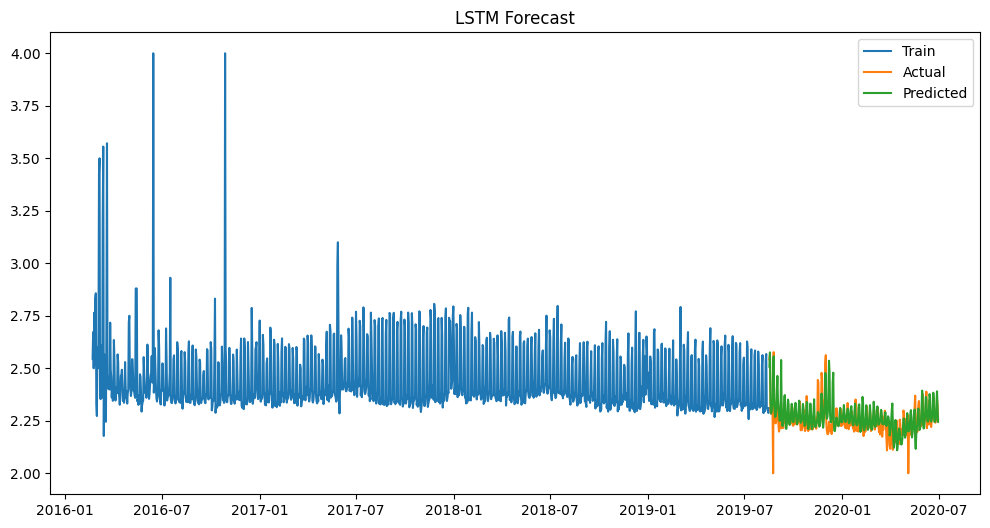

In [90]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_severity.values.reshape(-1,1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 14  # Increased sequence length for better pattern capture
X, y = create_sequences(scaled_data, seq_length)

# Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build model with dropout and custom learning rate
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))  # Increased units to 100
model.add(Dropout(0.2))  # Added dropout for regularization
model.add(LSTM(100))     # Increased units to 100
model.add(Dropout(0.2))  # Added dropout for regularization
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Fit model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert scaling
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('LSTM RMSE: %.3f' % rmse)

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_severity.index[seq_length:train_size+seq_length], y_train[0], label='Train')
test_start_idx = train_size + seq_length
test_length = len(y_test[0])
plt.plot(daily_severity.index[test_start_idx:test_start_idx + test_length], y_test[0], label='Actual')
plt.plot(daily_severity.index[test_start_idx:test_start_idx + test_length], test_predict[:,0], label='Predicted')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

The LSTM model for car accident severity forecasting, with an RMSE of 0.093, shows moderate performance over the 2016-2020 period. The predicted values capture the general downward trend but exhibit noticeable deviations from the actual values, particularly in the test phase. With a higher RMSE compared to exponential smoothing (0.029) and ARIMA (0.045), it suggests the model may need further optimization or tuning to improve accuracy for this dataset.

In [129]:
import pandas as pd

# Example RMSE values 
rmse_data = {
    "Model": ["Persist (Naïve)", "ARIMA", "Exponential Smoothing", "Prophet", "LSTM"],
    "RMSE": [0.062, 0.045, 0.029, 0.079, 0.065]  
}

# Create DataFrame
rmse_df = pd.DataFrame(rmse_data)

# Sort by RMSE (ascending = better)
rmse_df = rmse_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

# Style the table (bold the best model)
def highlight_best(row):
    if row["RMSE"] == rmse_df["RMSE"].min():
        return ['background-color: #e6ffe6' for _ in row]  # Light green
    else:
        return [''] * len(row)

styled_rmse = rmse_df.style.apply(highlight_best, axis=1) \
               .format({"RMSE": "{:.3f}"}) \
               .set_caption("RMSE Comparison Across Models (Lower is Better)")

styled_rmse

,Model,RMSE
0,Exponential Smoothing,0.029
1,ARIMA,0.045
2,Persist (Naïve),0.062
3,LSTM,0.065
4,Prophet,0.079


Among all the models evaluated for forecasting daily car accident severity, Exponential Smoothing emerged as the most accurate, achieving the lowest RMSE of 0.029, indicating its strong ability to capture the underlying trend and seasonality in the data. ARIMA followed with an RMSE of 0.045, also performing well due to its strength in modeling autocorrelated patterns. Simpler baseline methods like the Naïve (Persist) model yielded higher error (RMSE = 0.062), while more complex models like LSTM (0.065) and Prophet (0.079) did not outperform traditional statistical approaches. This outcome suggests that the accident severity time series may have relatively smooth and linear patterns that are better handled by classical models. Therefore, Exponential Smoothing is the most reliable and effective model for this particular forecasting task, and should be prioritized for any further prediction or deployment work.

## Achieving Predictive Insights for Accident Severity
This project successfully developed two types of predictive models to analyze accident severity:

Time Series Forecasting (Exponential Smoothing, ARIMA, LSTM, Prophet)

Classification (XGBoost, LightGBM, LSTM, Random Forest, etc.)

### Key Findings


Best Time Series Model: Exponential Smoothing (RMSE: 0.029) outperformed ARIMA, LSTM, and Prophet, demonstrating its effectiveness in capturing temporal patterns in daily accident severity.

Best Classification Model: XGBoost (Accuracy: 91.6%) achieved the highest performance in classifying accident severity, followed closely by LightGBM (91.4%) and LSTM (91.0%).

Comparison Insights:

Time series models (Exponential Smoothing) excel in forecasting trends, while ensemble methods (XGBoost) dominate in classification tasks.

LSTM performed moderately in both tasks, suggesting that while deep learning is powerful, traditional statistical and tree-based models may be more efficient for this dataset.

### Impact on Transportation Safety & Policy
Proactive Risk Management: Accurate severity forecasts (via Exponential Smoothing) can help agencies allocate emergency resources more efficiently.

Insurance & Policy Decisions: High-accuracy classification (XGBoost/LightGBM) enables better risk assessment for insurers and targeted safety interventions.

### Limitations & Future Work:

Hybrid approaches (e.g., combining time series with feature-engineered classification) could further improve predictions.

Real-world deployment should consider model interpretability (e.g., SHAP analysis for XGBoost) alongside accuracy.

Test ensemble models (e.g., stacking time series + classification outputs).

Incorporate external factors (weather, traffic) to improve real-world applicability.

### Final Recommendation:

For Forecasting: Use Exponential Smoothing for its balance of accuracy and simplicity.

For Classification: Deploy XGBoost due to its superior performance and robustness.

This project demonstrates that data-driven modeling can significantly enhance accident severity prediction, supporting safer transportation systems and evidence-based policy decisions.






